# Predict target features (brown dwarf parameters) using trained CNN model

In [1]:
# This allows you to automatically reload the imported module every time you make changes to it, 
%load_ext autoreload
%autoreload 2

# Define and Load the telescopeML modules
import sys  
sys.path.insert(0, '../telescopeML/')

from io_funs import load_or_dump_trained_model_CNN
from ObservPredictor import *
from DeepRegBuilder import *
from StatVisAnalyzer import regression_report, chi_square_test, plot_chi_square_p_value

Loading BokehJS ...

Loading BokehJS ...

# Step 1: Load the training dataset (syntheric spectra)

In [2]:
# original trainign dataset astronomers use to predict the parameters of the telescope brown dwarf spectra

train_BD = pd.read_csv('../../datasets/browndwarf_R100_v4_newWL_v2.csv.bz2', compression='bz2')
train_BD.head(3)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no


### Check the columns
note: one of the columns, *is_augmented*, is indicating wheter this is a native dataset or an augmented one. For now, we don't need it so drop it, but all modules will take this into account! 

In [3]:
target_features = ['gravity', 'temperature', 'c_o_ratio', 'metallicity']
train_BD[target_features].head()

,gravity,temperature,c_o_ratio,metallicity
0,5.0,1100,0.25,-1.0
1,5.0,1100,0.25,-0.7
2,5.0,1100,0.25,-0.5
3,5.0,1100,0.25,-0.3
4,5.0,1100,0.25,0.0


In [4]:
training_features_labels = [item for item in train_BD.columns.to_list() if item not in target_features+['is_augmented']]
training_features_labels[:5]

['2.512', '2.487', '2.462', '2.438', '2.413']

In [5]:
training_features_wl = [float(item) for item in train_BD.columns.to_list() if item not in target_features+['is_augmented']]
training_features_wl[:5]

[2.512, 2.487, 2.462, 2.438, 2.413]

In [6]:
wl = pd.read_csv('../../datasets/wl.csv')
wl.head(3)

,wl
0,2.511960
1,2.486966
2,2.462220


## Prepare feature variables (X) and targets (y)

In [7]:
# to assure we are only training the module with the native non-augmented BD training dataset
train_BD = train_BD[train_BD['is_augmented'].isin(['no'])] 


# Training feature variables
X = train_BD.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity', 
             'is_augmented'])#.astype(np.float32)


# Target feature variables
y = train_BD[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]#.astype(np.float32)


In [8]:
y.loc[:, 'temperature'] = np.log10(y['temperature'])

In [9]:
y.head()

,gravity,c_o_ratio,metallicity,temperature
0,5.0,0.25,-1.0,3.041393
1,5.0,0.25,-0.7,3.041393
2,5.0,0.25,-0.5,3.041393
3,5.0,0.25,-0.3,3.041393
4,5.0,0.25,0.0,3.041393


---

# Step 2: Build the CNN model / Data processing

In [10]:
# Instintiate BuildCNN class
build_cnn_regression = BuildCNN( 
                             feature_values=X.to_numpy(),
                             feature_names=X.columns,
                             target_values=y.to_numpy(),
                             target_name=['gravity', 'c_o_ratio', 'metallicity', 'temperature'],
                             is_tuned='yes',
                             param_grid=None,
                             spectral_resolution=100,
                             is_feature_improved='no',
                             is_augmented='no',
                             ml_model=None,
                             ml_model_str='CNN',
                                )

#### Split the dataset into train, validate and test sets

In [11]:
build_cnn_regression.split_train_validation_test(test_size=0.1, val_size=0.1, random_state_=100,)

In [12]:
# Scale the X features using MinMax Scaler
build_cnn_regression.standardize_X_row_wise()

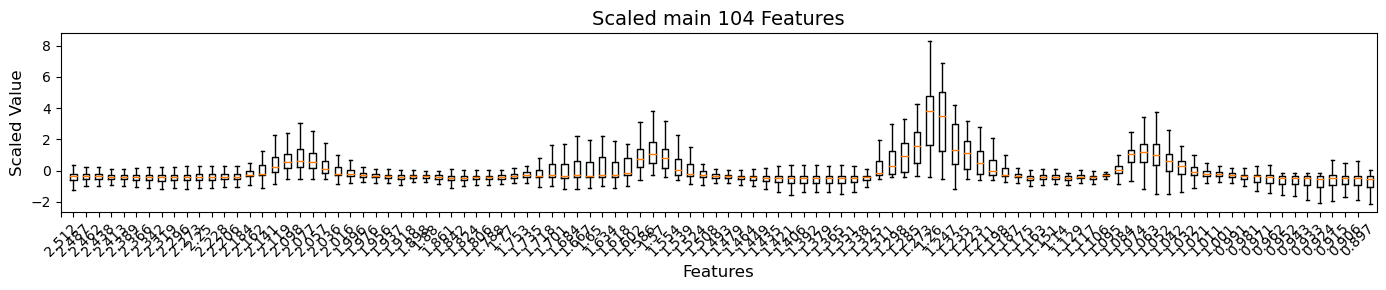

In [13]:
build_cnn_regression.plot_boxplot_scaled_features(scaled_feature= build_cnn_regression.X_train_standardized_rowwise, 
                                                  xticks_list = training_features_labels,
                                                  title = 'Scaled main 104 Features',
                                                  fig_size=(14, 3),
                                                    )

### Scale y features - ColumnWise

In [14]:
# Standardize the y features using Standard Scaler
build_cnn_regression.standardize_y_column_wise()

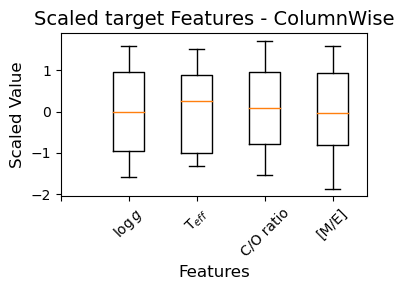

In [15]:
build_cnn_regression.plot_boxplot_scaled_features(scaled_feature= build_cnn_regression.y_train_standardized_columnwise, 
                                                  xticks_list = ['','$\log g$', 'T$_{eff}$', 'C/O ratio', '[M/E]'],
                                                  title = 'Scaled target Features - ColumnWise',
                                                  fig_size=(4, 3),
                                                    )

In [16]:
# build_cnn_regression.y_train_standardized_columnwise

### Feature engeenering: Take Min and Max of each row (BD spectra) 

In [17]:
# train
build_cnn_regression.X_train_min = build_cnn_regression.X_train.min(axis=1)
build_cnn_regression.X_train_max = build_cnn_regression.X_train.max(axis=1)

# validation
build_cnn_regression.X_val_min = build_cnn_regression.X_val.min(axis=1)
build_cnn_regression.X_val_max = build_cnn_regression.X_val.max(axis=1)

# test
build_cnn_regression.X_test_min = build_cnn_regression.X_test.min(axis=1)
build_cnn_regression.X_test_max = build_cnn_regression.X_test.max(axis=1)

In [18]:
df_MinMax_train = pd.DataFrame((build_cnn_regression.X_train_min, build_cnn_regression.X_train_max)).T
df_MinMax_val = pd.DataFrame((build_cnn_regression.X_val_min, build_cnn_regression.X_val_max)).T
df_MinMax_test = pd.DataFrame((build_cnn_regression.X_test_min, build_cnn_regression.X_test_max)).T

In [19]:
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)

In [20]:
df_MinMax_train.head()

,min,max
0,2.984493e-18,4.560593e-11
1,6.833671e-15,2.317328e-09
2,2.870361e-14,5.564836e-09
3,5.696652e-19,5.071436e-11
4,1.321553e-10,1.636513e-07


### Scale Min Max features - ColumnWise

In [21]:
build_cnn_regression.standardize_X_column_wise(
                                                X_train = df_MinMax_train.values,
                                                X_val   = df_MinMax_val.values,
                                                X_test  = df_MinMax_test.values,
                                                )

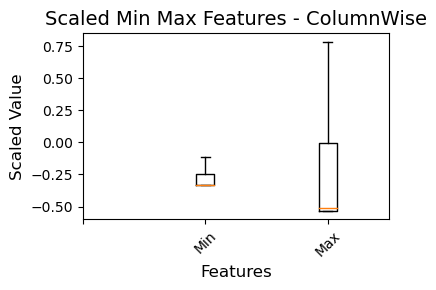

In [22]:
build_cnn_regression.plot_boxplot_scaled_features(scaled_feature= build_cnn_regression.X_test_standardized_columnwise, 
                                                  xticks_list = ['','Min','Max'],
                                                  title = 'Scaled Min Max Features - ColumnWise',
                                                  fig_size=(4, 3),
                                                    )

# Step 3: Load the Trained CNN model

In [23]:
loaded_model, history = load_or_dump_trained_model_CNN(indicator='Toy_parameters_v4_1000epoch_v2',
                                                      load_or_dump = 'load')

2023-08-08 11:52:54.605386: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
build_cnn_regression.trained_model = loaded_model
build_cnn_regression.trained_model_history = history

### Check the CNN archeticture

In [26]:
tf.keras.utils.plot_model(
                build_cnn_regression.trained_model,
                # to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
#                 show_layer_activations=False,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [27]:
build_cnn_regression.trained_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 104, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 102, 32)      128         input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 100, 64)      6208        conv1d_20[0][0]                  
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 98, 128)      24704       conv1d_21[0][0]                  
____________________________________________________________________________________________

### Check the performance of the trained models

In [28]:
build_cnn_regression.plot_model_loss(history=history, title = 'X:StandRow, y:StandCol - MinMax:StandCol, ToyCNNmodel')

### Plot predicted Vs. Actual outcomes: Histogram & Scatter plot

2023-08-08 11:56:11.252613: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


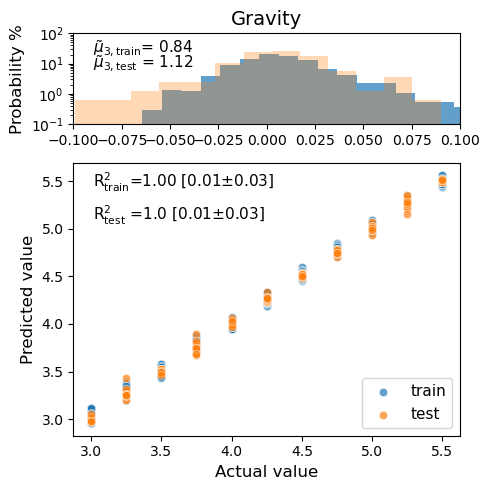

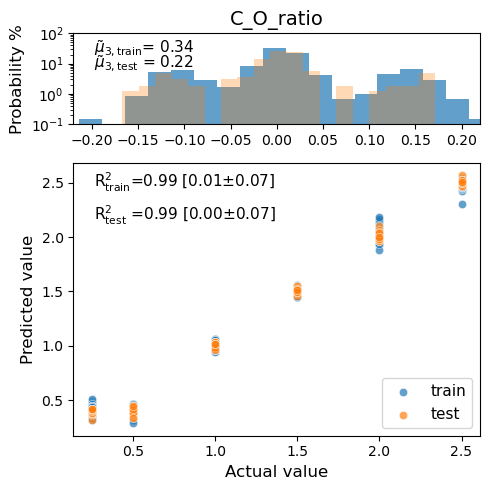

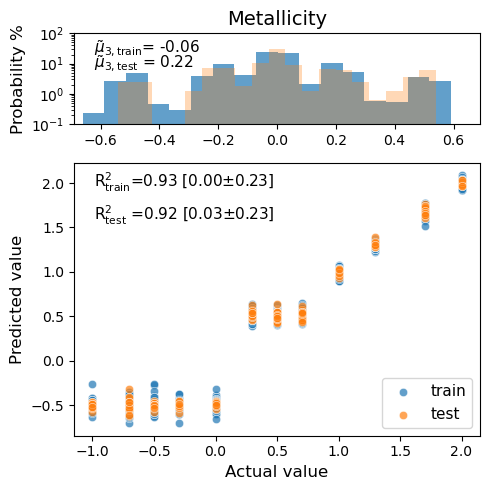

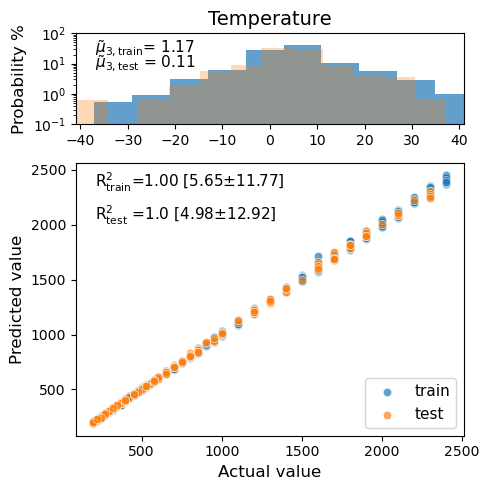

In [29]:
i = 19
regression_report(
        trained_model = build_cnn_regression,
    
        Xtrain = [build_cnn_regression.X_train_standardized_rowwise[::i],
                  build_cnn_regression.X_train_standardized_columnwise[::i]],
    
        Xtest  = [build_cnn_regression.X_test_standardized_rowwise[::i], 
                  build_cnn_regression.X_test_standardized_columnwise[::i]],
    
        ytrain = build_cnn_regression.y_train_standardized_columnwise[::i],
    
        ytest  = build_cnn_regression.y_test_standardized_columnwise[::i],
    
        target_i = 4,
        
        xy_top   = [0.05, 0.7],
        xy_bottom= [0.05, 0.85],
        print_results = False,        
                 )

# Step 4: Predict Observational data using the trained CNN model

Steps: 
- Define the literature reported data for the object
- Instintiate ObsParameterPredictor class
- load_observational_spectra
    - replace negative Flam with zero
    - take the average of neibougrs for Flam_error <= 0
    - plot_observational_spectra_errorbar_
- Process_Observational_Dataset
    - Instintiate ProcessObservationalDataset class
    - define feature_names_synthetic and feature_names_obs
    - flux_interpolated
    - 

---

## HD 3651B

#### Define the literature data reported for this object


In [30]:

HD3651B_BD_literature_info = {'bd_name':'HD3651B',
          'bd_Teff':818,
          'bd_logg':3.94,
          'bd_met': -0.22, 
          'bd_distance_pc' : 11.134, 
          'bd_radius_Rjup' : 0.81,
          'bd_radius_Rjup_tuned': None} #0.81


#### Instintiate the *ObsParameterPredictor* class from *ObservPredictor* module

In [31]:
brown_dwarf_literature_info = HD3651B_BD_literature_info
predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = train_BD,
                                wl = wl, 
                                train_cnn_regression_class = build_cnn_regression,
                                bd_literature_dic = brown_dwarf_literature_info
                                )

In [32]:
# Load the observational spectra
predict.load_observational_spectra()

# Process the observational dataset
predict.Process_Observational_Dataset(
    __print_results__=False,
    __plot_predicted_vs_observed__=False,
    )

#### Deploy the trained CNN model & Predict the target features 

******************************

Predicted Targets from Randomly Generated Spectra:
{   'c_o_ratio': 1.2744240760803223,
    'gravity': 4.984133720397949,
    'metallicity': -0.3114086985588074,
    'temperature': 840.2510986328125}
******************************

            logg        c_o        met           T
count  10.000000  10.000000  10.000000   10.000000
mean    4.984134   1.274424  -0.311409  840.251099
std     0.165045   0.125915   0.096245   42.617073
min     4.728060   1.091218  -0.439458  768.605652
25%     4.867768   1.198332  -0.384239  827.528366
50%     4.993535   1.231237  -0.316245  837.105194
75%     5.021834   1.349021  -0.285427  871.272141
max     5.300708   1.531739  -0.157244  896.472656


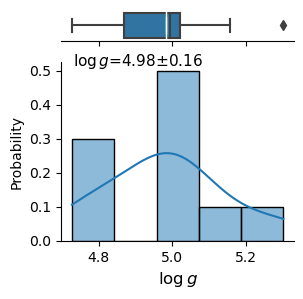

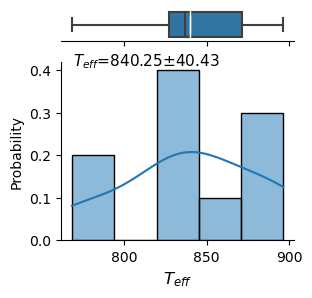

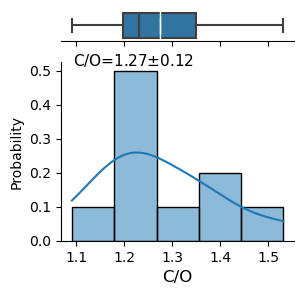

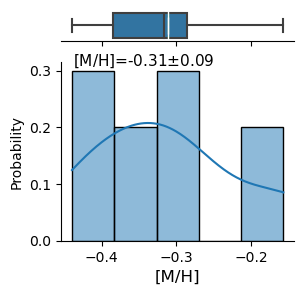

In [33]:
predict.predict_from_random_spectra(random_spectra_num= 10,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= False,
                                     __plot_histogram__= False,
                                     __plot_boxplot_hist__= True,
                                     __plot_predicted_vs_observed__= False,
                                     __plot_predicted_vs_spectra_errorbar__= False,
                                     __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

Comennet from natasha: >2.2 mincron - Is not missing any thing!
> 1 sigma error 
> training set
> trusing the posterior space 

### Tune the brown dwarf Radius

#### What is the 𝛘2 value for the predicted ML vs. the observational spectra?

In [34]:
chi_square_test(x_obs = predict.obs_data_df['wl'][2:], 
                y_obs = predict.Fnu_obs_absolute[2:], 
                yerr_obs = predict.Fnu_obs_absolute_err[2:],
                
                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                y_pre = predict.confidence_intervals_std_df['mean'], 
                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                __plot_results__ = False,
                __print_results__ = True)

Radius = 0.81 R_Jup:  𝛘2 = 58.78, p-value = 1.00e+00


(58.78, '1.00e+00')

#### What is the 𝛘2 value (and p-value) for a range of $R_{Jup}$ radius?

In [35]:
def tune_radius(Rmin=0.7, Rmax=1.2, dR=0.1,
                brown_dwarf_literature_info = None,
                __plot_results__ = False,
               __print_results__ = True,
               __plot_stat_results__ = True):
    R_list = []
    chi_square_list = []
    p_value_list = []

    for radius in list( np.linspace(Rmin, Rmax, num=int((Rmax-Rmin)/dR) )):
        
        brown_dwarf_literature_info['bd_radius_Rjup_tuned'] = radius
        
        predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                        training_dataset_df = train_BD,
                                        wl = wl, 
                                        train_cnn_regression_class = build_cnn_regression,
                                        bd_literature_dic = brown_dwarf_literature_info
                                        )
        predict.load_observational_spectra()

        predict.Process_Observational_Dataset(
        __print_results__=False,
        __plot_predicted_vs_observed__=False,
        )

        predict.predict_from_random_spectra(random_spectra_num= 5,
                                             __print_results__= False,
                                             __plot_randomly_generated_spectra__= False,
                                             __plot_histogram__= False,
                                             __plot_boxplot_hist__= False,
                                             __plot_predicted_vs_observed__= False,
                                             __plot_predicted_vs_spectra_errorbar__= False,
                                             __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = False,
                                             __calculate_confidence_intervals_std_df__ = True,
                                            )

        data1 = predict.Fnu_obs_absolute
        error1 = predict.Fnu_obs_absolute_err
        x1 = predict.obs_data_df['wl']

        data2 = predict.confidence_intervals_std_df['mean']
        error2 = predict.confidence_intervals_std_df['std_values']
        x2 = predict.confidence_intervals_std_df['wl'].values[::-1]

        # plot_with_errorbars(x1, data1, error1, x2, data2, error2, title="Data with Error Bars")

        chi_square, p_value = chi_square_test(x_obs = predict.obs_data_df['wl'], 
                                y_obs = predict.Fnu_obs_absolute, 
                                yerr_obs = predict.Fnu_obs_absolute_err,

                                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                                y_pre = predict.confidence_intervals_std_df['mean'], 
                                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                                radius = radius,
                                __plot_results__ = False,
                                __print_results__ = False)
        
        if chi_square >= 0.:
            R_list.append(radius)
            chi_square_list.append(chi_square)
            p_value_list.append(np.float128(p_value))
        else:
            pass

        if __print_results__:
            print( f"Radius = {'{:.2f}'.format(radius)} R_Jup:  𝛘2 = {chi_square}, p-value = {p_value}")
            
    if __plot_stat_results__:
        plot_chi_square_p_value(R_list, chi_square_list, p_value_list)
    
    return R_list, chi_square_list, p_value_list

In [36]:
print_results_fun(brown_dwarf_literature_info, print_title= 'HD3651B: Literature reported Info')

******************************

HD3651B: Literature reported Info
{   'bd_Teff': 818,
    'bd_distance_pc': 11.134,
    'bd_logg': 3.94,
    'bd_met': -0.22,
    'bd_name': 'HD3651B',
    'bd_radius_Rjup': 0.81,
    'bd_radius_Rjup_tuned': None}
******************************



In [37]:
R_list, chi_square_list, p_value_list = tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']- 0.3, 
                                                    Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+ 0.3, 
                                                    dR = 0.1,
                                                    brown_dwarf_literature_info = brown_dwarf_literature_info,
                                                    __plot_results__=False,
                                                    __print_results__=True,
                                                    __plot_stat_results__=True,)

Radius = 0.51 R_Jup:  𝛘2 = 110.02, p-value = 3.00e-01
Radius = 0.63 R_Jup:  𝛘2 = 94.72, p-value = 7.08e-01
Radius = 0.75 R_Jup:  𝛘2 = 135.39, p-value = 1.78e-02
Radius = 0.87 R_Jup:  𝛘2 = 84.55, p-value = 9.07e-01
Radius = 0.99 R_Jup:  𝛘2 = 87.67, p-value = 8.60e-01
Radius = 1.11 R_Jup:  𝛘2 = 175.96, p-value = 1.01e-05


---

## Ross 458C

#### Define the literature data reported for this object

In [ ]:
Ross458C_BD_literature_info = {'bd_name':'Ross458C',
          'bd_Teff':804,
          'bd_logg':4.09,
          'bd_met': 0.23, 
          'bd_distance_pc' : 11.509, 
          'bd_radius_Rjup' :  0.68,
          'bd_radius_Rjup_tuned': None } #1.0 * 0.68 


#### Instintiate the *ObsParameterPredictor* class from *ObservPredictor* module

In [ ]:
brown_dwarf_literature_info = Ross458C_BD_literature_info
predict_ = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = train_BD,
                                wl = wl, 
                                train_cnn_regression_class = build_cnn_regression,
                                bd_literature_dic = brown_dwarf_literature_info
                                )

In [ ]:
# Load the observational spectra
predict.load_observational_spectra()

# Process the observational dataset
predict.Process_Observational_Dataset(
    __print_results__=False,
    __plot_predicted_vs_observed__=False,
    )

#### Deploy the trained CNN model & Predict the target features 

In [ ]:
predict.predict_from_random_spectra(random_spectra_num= 100,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= False,
                                     __plot_histogram__= False,
                                     __plot_boxplot_hist__= True,
                                     __plot_predicted_vs_observed__= False,
                                     __plot_predicted_vs_spectra_errorbar__= False,
                                     __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

### Tune the brown dwarf Radius

#### What is the 𝛘2 value for the predicted ML vs. the observational spectra?

In [ ]:
chi_square_test(x_obs = predict.obs_data_df['wl'][2:], 
                y_obs = predict.Fnu_obs_absolute[2:], 
                yerr_obs = predict.Fnu_obs_absolute_err[2:],
                
                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                y_pre = predict.confidence_intervals_std_df['mean'], 
                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                __plot_results__ = False,
                __print_results__ = True)

#### What is the 𝛘2 value (and p-value) for a range of $R_{Jup}$ radius?

In [ ]:
def tune_radius(Rmin=0.7, Rmax=1.2, dR=0.1,
                brown_dwarf_literature_info = None,
                __plot_results__ = False,
               __print_results__ = True,
               __plot_stat_results__ = True):
    R_list = []
    chi_square_list = []
    p_value_list = []

    for radius in list( np.linspace(Rmin, Rmax, num=int((Rmax-Rmin)/dR) )):
        
        brown_dwarf_literature_info['bd_radius_Rjup_tuned'] = radius
        
        predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                        training_dataset_df = train_BD,
                                        wl = wl, 
                                        train_cnn_regression_class = build_cnn_regression,
                                        bd_literature_dic = brown_dwarf_literature_info
                                        )
        predict.load_observational_spectra()

        predict.Process_Observational_Dataset(
        __print_results__=False,
        __plot_predicted_vs_observed__=False,
        )

        predict.predict_from_random_spectra(random_spectra_num= 5,
                                             __print_results__= False,
                                             __plot_randomly_generated_spectra__= False,
                                             __plot_histogram__= False,
                                             __plot_boxplot_hist__= False,
                                             __plot_predicted_vs_observed__= False,
                                             __plot_predicted_vs_spectra_errorbar__= False,
                                             __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = False,
                                             __calculate_confidence_intervals_std_df__ = True,
                                            )

        data1 = predict.Fnu_obs_absolute
        error1 = predict.Fnu_obs_absolute_err
        x1 = predict.obs_data_df['wl']

        data2 = predict.confidence_intervals_std_df['mean']
        error2 = predict.confidence_intervals_std_df['std_values']
        x2 = predict.confidence_intervals_std_df['wl'].values[::-1]

        # plot_with_errorbars(x1, data1, error1, x2, data2, error2, title="Data with Error Bars")

        chi_square, p_value = chi_square_test(x_obs = predict.obs_data_df['wl'], 
                                y_obs = predict.Fnu_obs_absolute, 
                                yerr_obs = predict.Fnu_obs_absolute_err,

                                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                                y_pre = predict.confidence_intervals_std_df['mean'], 
                                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                                radius = radius,
                                __plot_results__ = False,
                                __print_results__ = False)
        
        if chi_square >= 0.:
            R_list.append(radius)
            chi_square_list.append(chi_square)
            p_value_list.append(np.float128(p_value))
        else:
            pass

        if __print_results__:
            print( f"Radius = {'{:.2f}'.format(radius)} R_Jup:  𝛘2 = {chi_square}, p-value = {p_value}")
            
    if __plot_stat_results__:
        plot_chi_square_p_value(R_list, chi_square_list, p_value_list)
    
    return R_list, chi_square_list, p_value_list

In [ ]:
print_results_fun(brown_dwarf_literature_info, print_title= 'Ross458C: Literature reported Info')

In [ ]:
R_list, chi_square_list, p_value_list = tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']- 0.2, 
                                                    Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+ 0.2, 
                                                    dR = 0.01,
                                                    brown_dwarf_literature_info = brown_dwarf_literature_info,
                                                    __plot_results__=False,
                                                    __print_results__=True,
                                                    __plot_stat_results__=True,)

---

## GJ 570D

#### Define the literature data reported for this object

In [ ]:
GJ570D_BD_literature_info = {'bd_name':'GJ570D',
          'bd_Teff':828,
          'bd_logg':3.90,
          'bd_met': -0.33, 
          'bd_distance_pc' : 5.884, 
          'bd_radius_Rjup' : 0.79,
          'bd_radius_Rjup_tuned': None } # 0.79

#### Instintiate the *ObsParameterPredictor* class from *ObservPredictor* module

In [ ]:
brown_dwarf_literature_info = GJ570D_BD_literature_info

predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = train_BD,
                                wl = wl, 
                                train_cnn_regression_class = build_cnn_regression,
                                bd_literature_dic = brown_dwarf_literature_info
                                )

In [ ]:
# Load the observational spectra
predict.load_observational_spectra()

# Process the observational dataset
predict.Process_Observational_Dataset(
    __print_results__=False,
    __plot_predicted_vs_observed__=False,
    )

#### Deploy the trained CNN model & Predict the target features 

In [ ]:
predict.predict_from_random_spectra(random_spectra_num= 100,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= False,
                                     __plot_histogram__= False,
                                     __plot_boxplot_hist__= True,
                                     __plot_predicted_vs_observed__= False,
                                     __plot_predicted_vs_spectra_errorbar__= False,
                                     __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

### Tune the brown dwarf Radius

#### What is the 𝛘2 value for the predicted ML vs. the observational spectra?

In [ ]:
chi_square_test(x_obs = predict.obs_data_df['wl'][2:], 
                y_obs = predict.Fnu_obs_absolute[2:], 
                yerr_obs = predict.Fnu_obs_absolute_err[2:],
                
                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                y_pre = predict.confidence_intervals_std_df['mean'], 
                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                __plot_results__ = False,
                __print_results__ = True)

#### What is the 𝛘2 value (and p-value) for a range of $R_{Jup}$ radius?

In [ ]:
def tune_radius(Rmin=0.7, Rmax=1.2, dR=0.1,
                brown_dwarf_literature_info = None,
                __plot_results__ = False,
               __print_results__ = True,
               __plot_stat_results__ = True):
    R_list = []
    chi_square_list = []
    p_value_list = []

    for radius in list( np.linspace(Rmin, Rmax, num=int((Rmax-Rmin)/dR) )):
        
        brown_dwarf_literature_info['bd_radius_Rjup_tuned'] = radius
        
        predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                        training_dataset_df = train_BD,
                                        wl = wl, 
                                        train_cnn_regression_class = build_cnn_regression,
                                        bd_literature_dic = brown_dwarf_literature_info
                                        )
        predict.load_observational_spectra()

        predict.Process_Observational_Dataset(
        __print_results__=False,
        __plot_predicted_vs_observed__=False,
        )

        predict.predict_from_random_spectra(random_spectra_num= 5,
                                             __print_results__= False,
                                             __plot_randomly_generated_spectra__= False,
                                             __plot_histogram__= False,
                                             __plot_boxplot_hist__= False,
                                             __plot_predicted_vs_observed__= False,
                                             __plot_predicted_vs_spectra_errorbar__= False,
                                             __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = False,
                                             __calculate_confidence_intervals_std_df__ = True,
                                            )

        data1 = predict.Fnu_obs_absolute
        error1 = predict.Fnu_obs_absolute_err
        x1 = predict.obs_data_df['wl']

        data2 = predict.confidence_intervals_std_df['mean']
        error2 = predict.confidence_intervals_std_df['std_values']
        x2 = predict.confidence_intervals_std_df['wl'].values[::-1]

        # plot_with_errorbars(x1, data1, error1, x2, data2, error2, title="Data with Error Bars")

        chi_square, p_value = chi_square_test(x_obs = predict.obs_data_df['wl'], 
                                y_obs = predict.Fnu_obs_absolute, 
                                yerr_obs = predict.Fnu_obs_absolute_err,

                                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                                y_pre = predict.confidence_intervals_std_df['mean'], 
                                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                                radius = radius,
                                __plot_results__ = False,
                                __print_results__ = False)
        
        if chi_square >= 0.:
            R_list.append(radius)
            chi_square_list.append(chi_square)
            p_value_list.append(np.float128(p_value))
        else:
            pass

        if __print_results__:
            print( f"Radius = {'{:.2f}'.format(radius)} R_Jup:  𝛘2 = {chi_square}, p-value = {p_value}")
            
    if __plot_stat_results__:
        plot_chi_square_p_value(R_list, chi_square_list, p_value_list)
    
    return R_list, chi_square_list, p_value_list

In [ ]:
print_results_fun(brown_dwarf_literature_info, print_title= 'GJ570D: Literature reported Info')

In [ ]:
R_list, chi_square_list, p_value_list = tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']- 0.2, 
                                                    Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+ 0.2, 
                                                    dR = 0.01,
                                                    brown_dwarf_literature_info = brown_dwarf_literature_info,
                                                    __plot_results__=False,
                                                    __print_results__=True,
                                                    __plot_stat_results__=True,)

### GJ 570D with optimised Radius

In [ ]:
GJ570D_BD_literature_info = {'bd_name':'GJ570D',
          'bd_Teff':828,
          'bd_logg':3.90,
          'bd_met': -0.33, 
          'bd_distance_pc' : 5.884, 
          'bd_radius_Rjup' : 0.77,
          'bd_radius_Rjup_tuned': None } # Original radius = 0.79

In [ ]:
brown_dwarf_literature_info = GJ570D_BD_literature_info

predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = train_BD,
                                wl = wl, 
                                train_cnn_regression_class = build_cnn_regression,
                                bd_literature_dic = brown_dwarf_literature_info
                                )

In [ ]:
# Load the observational spectra
predict.load_observational_spectra()

# Process the observational dataset
predict.Process_Observational_Dataset(
    __print_results__=False,
    __plot_predicted_vs_observed__=False,
    )

In [ ]:
predict.predict_from_random_spectra(random_spectra_num= 100,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= False,
                                     __plot_histogram__= False,
                                     __plot_boxplot_hist__= True,
                                     __plot_predicted_vs_observed__= False,
                                     __plot_predicted_vs_spectra_errorbar__= False,
                                     __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

---

#                      THE  END 